In [1]:
import landlab
from landlab.components import FlowAccumulator
from landlab.io import read_esri_ascii, write_esri_ascii
from landlab.plot import imshow_grid
import SALib


print(landlab.__file__)
print(SALib.__file__)

/Users/njlyons/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/njlyons/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


/Users/njlyons/Code/landlab/landlab/__init__.py
/Users/njlyons/Code/SALib/SALib/__init__.py


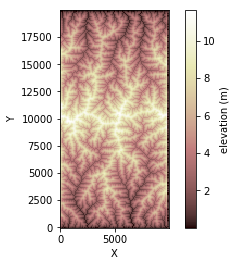

In [4]:
path = 'topographic__elevation.asc'
mg, z = read_esri_ascii(path, name='topographic__elevation')
fa = FlowAccumulator(mg, flow_director='FlowDirectorD8')
fa.run_one_step()

imshow_grid(mg, z, colorbar_label='elevation (m)')